In [12]:
from dotenv import load_dotenv

import os

load_dotenv()

True

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [13]:
from tools import *

In [14]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Beatriz Haddad Maia', 'Cessar-fogo Gaza', 'AZUL4']

In [15]:
contents_news = get_serper_with_scrapping(trends_list, k=5)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:06<00:00,  2.21s/it]


In [16]:
contents_news

{'Beatriz Haddad Maia': [{'title': 'Jo√£o Fonseca e Bia Haddad t√™m destinos diferentes no Australian Open',
   'link': 'https://www.terra.com.br/esportes/tenis/joao-fonseca-e-bia-haddad-tem-destinos-diferentes-no-australian-open,e5ba253fafc4b493303b219c76c11dc3vgg2a7ma.html',
   'snippet': 'A madrugada no Australian Open 2025 trouxe emo√ß√µes contrastantes para os torcedores brasileiros. Beatriz Haddad Maia e Jo√£o Fonseca,...',
   'date': 'h√° 2 horas',
   'source': 'Terra',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZPamYXb3axNUZEo7rXv7PzkqhFeffRHmJ7lT0VgmCV3yrVTx6uRaG_dM&usqp=CAI&s',
   'position': 1,
   'content': "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJo√£o Fonseca e Bia Haddad t√™m destinos diferentes no Australian Open\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nScript = https://s1.trrsf.com/update-1736967909/fe/zaz-ui-t360/_js/transition.min.js\nScript = https://pagead2.googlesyndication.com

## Constru√ß√£o do Agent

Para construir o agente, vamos utilizar as fun√ß√µes que construimos anteriormente. A ideia central √© um agente que colete quais s√£o as tend√™ncias de pesquisa no Google Trends, pesquise essas tend√™ncias no Google Api (SerpApi), fa√ßa scrapping dos resultados e crie uma newsletter com as informa√ß√µes. Para a constru√ß√£o desses fluxos, √© comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente s√£o:

1. ``Estado``: √© o objeto que ir√° armazenar as informa√ß√µes do agente ao longo do grafo.
2. ``N√≥s``: s√£o as fun√ß√µes que ir√£o realizar as a√ß√µes do agente.
3. ``Transi√ß√µes (arestas)``: s√£o as fun√ß√µes que ir√£o decidir qual ser√° o pr√≥ximo n√≥ a ser executado (ela pode ser condicional ou n√£o).

### Estado do Grafo

In [17]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    subjects: List[str] # New attribute
    newsletter: str

### Chains

Aqui definimos as cadeias de execu√ß√£o do agente. Normalmente separamos dessa forma pra que a constru√ß√£o dos n√≥s fique mais organizada.

In [18]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugest√£o: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    elif provider == "groq": # Sugest√£o: llama-3.3-70b-versatile
        llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Voc√™ √© um assistente pessoal que vai escrever um newsletter sobre as not√≠cias do dia que foram extraidas do Google Trends. Sua tarefa √© resumir o conte√∫do das not√≠cias e escrever um texto informativo e interessante para o usu√°rio. 
    
    Obs.: Sempre que poss√≠vel, cite a fonte das not√≠cias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui est√° todo o conte√∫do que voc√™ vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

### Nodes

Aqui vamos definir os n√≥s do grafo! Como dito anteriormente, entenda os n√≥s como sendo fun√ß√µes a serem executadas. Cada entrada de um n√≥ √© a sa√≠da de um n√≥ anterior, cada execu√ß√£o de n√≥ podemos ou n√£o modificar o estado do grafo (definido anteriormente).

In [19]:
from IPython.display import Markdown

def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui est√° a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}

### Workflow

Por fim, com os n√≥s construidos e as cadeias definidas, podemos construir o workflow do agente.

In [20]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("create_newsletter", create_newsletter)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "create_newsletter")
    workflow.add_edge("create_newsletter", END)

    # Compile
    app = workflow.compile()
    return app

In [21]:
app = compile_workflow()

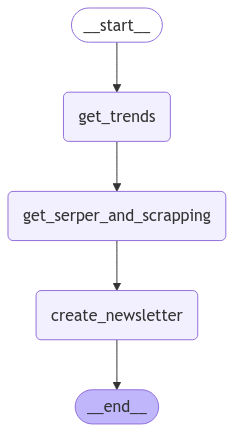

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
response = app.invoke({"country": "brazil",
                       "head": 5,
                       "subjects": ["Educa√ß√£o"],
                       "k": 3})

---GET TRENDS---

--> Assuntos adicionais:  ['Educa√ß√£o']
Trend List:  ['Beatriz Haddad Maia', 'Cessar-fogo Gaza', 'AZUL4', 'Jogo joao Fonseca', 'Matheus Pereira']

---GET SERPER AND SCRAPPING---



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:13<00:00,  2.22s/it]


---Beatriz Haddad Maia---
Jo√£o Fonseca e Bia Haddad t√™m destinos diferentes no Australian Open
Bia Haddad joga o suficiente e avan√ßa √† terceira rodada no Australian Open
Bia Haddad avan√ßa no Australian Open; Jo√£o Fonseca √© eliminado

---Cessar-fogo Gaza---
Israel ataca a Faixa de Gaza depois de aprovar acordo de cessar-fogo
Cessar-fogo em Gaza: as perguntas ainda sem resposta sobre o acordo, que teve vota√ß√£o adiada em Israel
Gabinete de Israel adia vota√ß√£o sobre cessar-fogo em Gaza

---AZUL4---
Gol (GOLL4) e Azul (AZUL4) assinam acordo visando fus√£o
A√ß√µes de Azul (AZUL4) e Gol (GOLL4) disparam com acordo para avaliar fus√£o
Mercado financeiro hoje: Azul (AZUL4) e Gol (GOLL4) chegam a acordo sobre fus√£o, Pagbank e Stone t√™m cortes de recomenda√ß√£o; veja destaques

---Jogo joao Fonseca---
Quando √© o pr√≥ximo jogo de Jo√£o Fonseca? Veja onde assistir ao vivo, dia e hor√°rio
Australian Open: Jo√£o Fonseca perde para Sonego em batalha de quase 4h
Jo√£o Fonseca come√ßa com 

**Newsletter de Not√≠cias - 16 de Janeiro de 2025**

**1. Australian Open: Bia Haddad avan√ßa, Jo√£o Fonseca √© eliminado**
A madrugada de ontem trouxe emo√ß√µes contrastantes para os torcedores brasileiros no Australian Open. Beatriz Haddad Maia venceu a russa Erika Andreeva com parciais de 6/2 e 6/3, garantindo sua vaga na terceira rodada. Bia, atual n√∫mero 14 do mundo, agora se prepara para enfrentar Madison Keys. Por outro lado, Jo√£o Fonseca, de apenas 18 anos, lutou bravamente contra Lorenzo Sonego, mas foi eliminado ap√≥s uma batalha de quase quatro horas, com parciais de 6/7, 6/3, 6/1, 3/6 e 6/3. Apesar da derrota, Fonseca deixou o torneio com a certeza de que tem um futuro promissor no t√™nis. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/esportes/tenis/bia-haddad-avanca-no-australian-open-joao-fonseca-e-eliminado/).

**2. Cessar-fogo em Gaza: Ataques continuam ap√≥s acordo**
Ap√≥s um acordo de cessar-fogo entre Israel e Hamas, a situa√ß√£o em Gaza permanece tensa. Israel lan√ßou ataques que resultaram na morte de pelo menos 81 palestinos, o maior n√∫mero de v√≠timas em um √∫nico dia em mais de uma semana. A situa√ß√£o levanta preocupa√ß√µes sobre a efic√°cia do cessar-fogo e a seguran√ßa dos civis na regi√£o. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/internacional/israel-ataca-a-faixa-de-gaza-depois-de-aprovar-acordo-de-cessar-fogo/).

**3. Gol e Azul assinam acordo para fus√£o**
As companhias a√©reas Gol e Azul assinaram um memorando de entendimento para explorar uma fus√£o que poderia resultar em uma nova empresa controlando 60% do mercado a√©reo brasileiro. A fus√£o depende da conclus√£o da recupera√ß√£o judicial da Gol, prevista para abril. [Leia mais no InfoMoney](https://www.infomoney.com.br/mercados/acoes-de-azul-azul4-e-gol-goll4-disparam-com-acordo-para-avaliar-fusao/).

**4. Programa Mais Professores √© lan√ßado**
O governo federal lan√ßou o programa Mais Professores, que visa valorizar e qualificar cerca de 2,3 milh√µes de docentes no Brasil. O programa inclui a√ß√µes como a cria√ß√£o de uma Prova Nacional Docente e a oferta de bolsas de R$ 1.050 para estudantes de licenciatura. O objetivo √© atrair novos professores e melhorar a qualidade da educa√ß√£o no pa√≠s. [Leia mais na CartaCapital](https://www.cartacapital.com.br/educacao/governo-lanca-o-mais-professores-entenda-os-principais-pontos-do-programa/).

**5. Lei que restringe uso de celulares em escolas**
Uma nova lei sancionada pelo presidente Lula pro√≠be o uso de celulares em escolas de educa√ß√£o b√°sica, visando promover um ambiente escolar mais saud√°vel. Educadores e especialistas divergem sobre a efic√°cia da medida, ressaltando a necessidade de apoio dos pais e da comunidade escolar para sua implementa√ß√£o. [Leia mais no O Tempo](https://www.otempo.com.br/brasil/2025/1/16/especialistas-da-educacao-divergem-sobre-lei-federal-que-proibe-o-uso-do-celular-em-sala-de-aula0).

**6. Matheus Pereira fala sobre futuro no Cruzeiro**
Ap√≥s marcar um gol rel√¢mpago no empate contra o S√£o Paulo, Matheus Pereira admitiu que recebeu propostas de outros clubes, mas n√£o confirmou sua perman√™ncia no Cruzeiro. O jogador expressou sua felicidade em estar no clube, mas deixou seu futuro em aberto. [Leia mais na CNN Brasil](https://www.cnnbrasil.com.br/esportes/futebol/cruzeiro-x-sao-paulo-veja-o-gol-de-matheus-pereira-com-30-segundos-de-jogo/).

Fique atento √†s atualiza√ß√µes e n√£o perca as pr√≥ximas edi√ß√µes!

## Conclus√£o:

Com essa aplica√ß√£o simples √© poss√≠vel ver como podemos construir um agente que coleta informa√ß√µes de tend√™ncias de pesquisa e cria uma newsletter. Para al√©m dessa ideia, √© poss√≠vel construir aplica√ß√µes mais robustas, que envolvem ``novos n√≥s, novas cadeias, novos estados ou at√© transi√ß√µes condicionais``. 

### Tarefa de casa:

1. Crie um novo n√≥ que envie a newsletter por email. Note que para isso voc√™ precisa incluir uma lista de emails que ir√£o receber a newsletter. (``Dica:`` Fa√ßa a lista de emails ser um par√¢metro na entrada do grafo, assim voc√™ pode passar a lista de emails como par√¢metro para o n√≥ que envia a newsletter).

2. Calcule quanto custa em m√©dia uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as not√≠cias de acordo com o assunto. Especificamente, classifique se a not√≠cia fala sobre futebol ou n√£o (``bin√°rio``). No fim, fa√ßa a newsletter somente baseada em assuntos de futebol (seu classificador ser√° um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou n√£o de futebol. Caso n√£o tenha noticias de futebol no Google Trends, crie um n√≥ que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.